IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import catboost


import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn import svm
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb

pd.set_option('display.max_columns', 100)  #By increasing the limit to 100, you ensure that all columns are visible in the dataframe

RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier

#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation

#Random seed
RANDOM_STATE = 2018

#LightGBM Training Parameters
MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

# IS_LOCAL = False

READ THE DATA

In [2]:
df = pd.read_csv('creditcard.csv')
df.shape

(284807, 31)

In [3]:
df.sample(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
247079,153448.0,-0.172532,0.797751,0.588849,-0.667258,0.562609,-1.028146,1.069351,-0.205061,-0.227407,-0.697423,-1.023502,-0.159590,-0.503677,0.291632,-0.362736,-0.162821,-0.323760,-0.740040,-0.087813,-0.191838,-0.173776,-0.465133,0.030275,-0.024211,-0.743283,0.102900,0.114659,0.180109,1.98,0
266150,162211.0,1.820889,-0.554517,-0.925243,1.581046,-0.186132,0.189913,-0.274316,0.066028,1.388006,0.042293,-1.818030,-0.115290,-1.290325,-0.096481,-1.171606,-0.669495,0.070298,-0.026975,-0.153988,-0.187235,0.274480,1.007327,-0.136422,0.632882,0.427326,-0.273785,0.021988,-0.033915,83.25,0
106464,69977.0,-0.274335,1.314194,0.734878,0.989641,-0.166931,-0.820418,0.438937,0.193826,-0.875027,-0.401183,-0.447612,0.697352,1.268035,0.391607,0.851575,-0.202043,-0.109107,-0.022544,0.336402,-0.062766,0.187170,0.515846,-0.069467,0.422357,-0.093547,-0.331539,-0.036234,-0.015708,9.82,0
205947,135991.0,0.458688,0.806535,-0.296523,-0.262852,-0.002800,-0.610562,-0.505378,-2.932717,-0.265354,-1.009864,-0.788663,0.873860,0.364699,0.567194,-0.404763,0.171828,-0.334335,-0.933139,-0.462915,0.483273,-1.559989,-0.401851,0.173449,0.049983,0.432632,0.214420,-0.038255,0.140947,1.98,0
226829,144816.0,0.982582,-1.910159,-1.245638,0.729821,-0.809566,0.405102,-0.284157,0.156819,1.013806,-0.588626,0.821725,0.521798,-0.025371,-1.265597,0.354256,1.472315,-0.033715,1.370002,-0.243665,0.917542,0.272312,-0.280708,-0.160699,0.276054,-0.731778,0.266837,-0.095988,0.072204,512.50,0
32821,36979.0,-0.722121,0.655166,1.415336,0.383292,0.118910,-0.041463,1.625110,-0.592798,-0.382368,-0.008828,0.457493,0.364878,1.321159,-1.024828,1.479256,-0.358328,0.228033,-0.674113,0.237857,0.398895,-0.292056,-0.303444,0.041801,0.077404,-0.483697,0.113047,-0.001636,-0.277703,179.99,0
131676,79693.0,0.251547,-1.258393,-0.118342,1.459277,-0.587882,0.068748,0.535921,-0.009899,-0.263036,-0.012212,1.429704,0.722315,-0.432281,0.747332,0.595560,0.135798,-0.405898,0.127024,-0.688341,0.752967,0.425415,0.198841,-0.496109,0.033114,0.385274,-0.316022,-0.059596,0.088171,468.07,0
7003,9168.0,1.251257,0.436298,-0.823469,1.523736,2.429591,3.754731,-0.528716,0.784007,0.418469,0.389772,0.607532,-2.795007,1.655072,1.850994,-0.055720,0.947995,-0.393259,0.518705,-0.885362,-0.068513,-0.150686,-0.354646,-0.094278,0.939638,0.696627,0.044729,-0.035922,0.007848,4.62,0
230506,146358.0,1.891452,-0.072069,-2.525160,0.385495,2.532536,3.527973,-0.531228,0.928476,0.379769,-0.323425,0.313233,0.247064,-0.228619,-0.801866,0.750079,0.464519,0.331892,-0.206187,-0.520977,-0.089724,-0.495045,-1.526626,0.473447,0.487369,-0.395428,-1.153357,0.060689,-0.003317,37.99,0
17129,28468.0,-0.354615,-0.333226,-0.766329,-3.484571,1.194149,3.072668,-1.162841,1.294132,-2.392941,0.910323,-0.634991,-1.103008,0.408192,-0.047189,0.018462,0.246970,-0.123088,0.507175,-0.567987,-0.215927,-0.171215,-0.350987,0.030448,0.957568,-0.025851,-0.389862,0.184963,0.019550,15.00,0


In [4]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,1.673327e-15,-1.247012e-15,8.190001e-16,1.207294e-15,4.887456e-15,1.437716e-15,-3.772171e-16,9.564149e-16,1.039917e-15,6.406204e-16,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


CHECKING MISSING DATA

In [5]:
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()
#there are no missing values in the dataset

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


EXPLORING DATA IMBALANCY

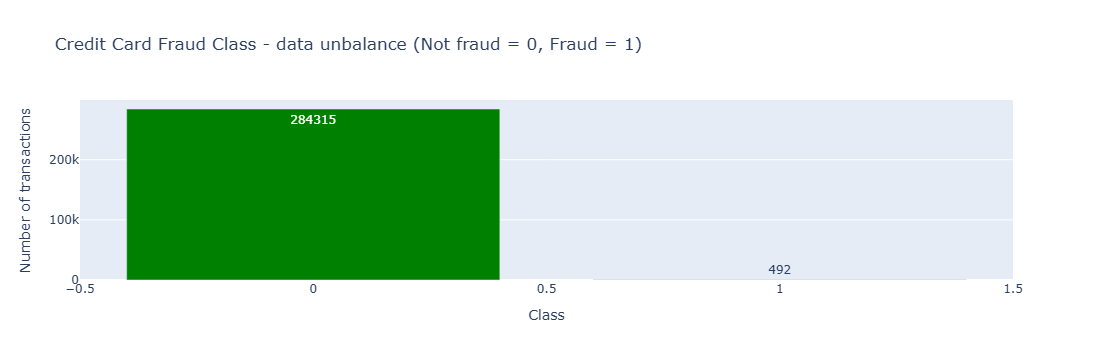

In [6]:
temp = df["Class"].value_counts()
# temp
data_df = pd.DataFrame({'Class': temp.index,'values': temp.values}) #temp.index: Contains the class labels (0 and 1)
                                                                    #temp.values: Contains the corresponding counts

trace = go.Bar(
    x = data_df['Class'],y = data_df['values'],
    name="Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)",
    marker=dict(color="green"),
    text=data_df['values']
)
data = [trace]
layout = dict(title = 'Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)',
          xaxis = dict(title = 'Class', showticklabels=True), 
          yaxis = dict(title = 'Number of transactions'),
          hovermode = 'closest',width=700
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='class')
# Only 492 (or 0.172%) of transaction are fraudulent. That means the data is highly unbalanced with respect with target variable Class.

EXPLORING SOME MORE FEATURES: 1) TRANSACTION IN TERMS OF TIME

In [7]:
class_0 = df.loc[df['Class'] == 0]["Time"]
class_1 = df.loc[df['Class'] == 1]["Time"]
# class_0.sample(5)
hist_data = [class_0, class_1]
group_labels = ['Not Fraud', 'Fraud']

fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
fig['layout'].update(title='Credit Card Transactions Time Density Plot', xaxis=dict(title='Time [s]'))
iplot(fig, filename='dist_only')

Fraudulent transactions have a distribution more even than valid transactions - are equaly distributed in time, including the low real transaction times, during night in Europe timezone.


In [8]:
df['Hour'] = df['Time'].apply(lambda x: np.floor(x / 3600))

tmp = df.groupby(['Hour', 'Class'])['Amount'].aggregate(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()
data_df = pd.DataFrame(tmp)
data_df.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']
data_df.head()

,Hour,Class,Min,Max,Transactions,Sum,Mean,Median,Var
0,0.0,0,0.0,7712.43,3961,256572.87,64.774772,12.990,45615.821201
1,0.0,1,0.0,529.00,2,529.00,264.500000,264.500,139920.500000
2,1.0,0,0.0,1769.69,2215,145806.76,65.826980,22.820,20053.615770
3,1.0,1,59.0,239.93,2,298.93,149.465000,149.465,16367.832450
4,2.0,0,0.0,4002.88,1555,106989.39,68.803466,17.900,45355.430437


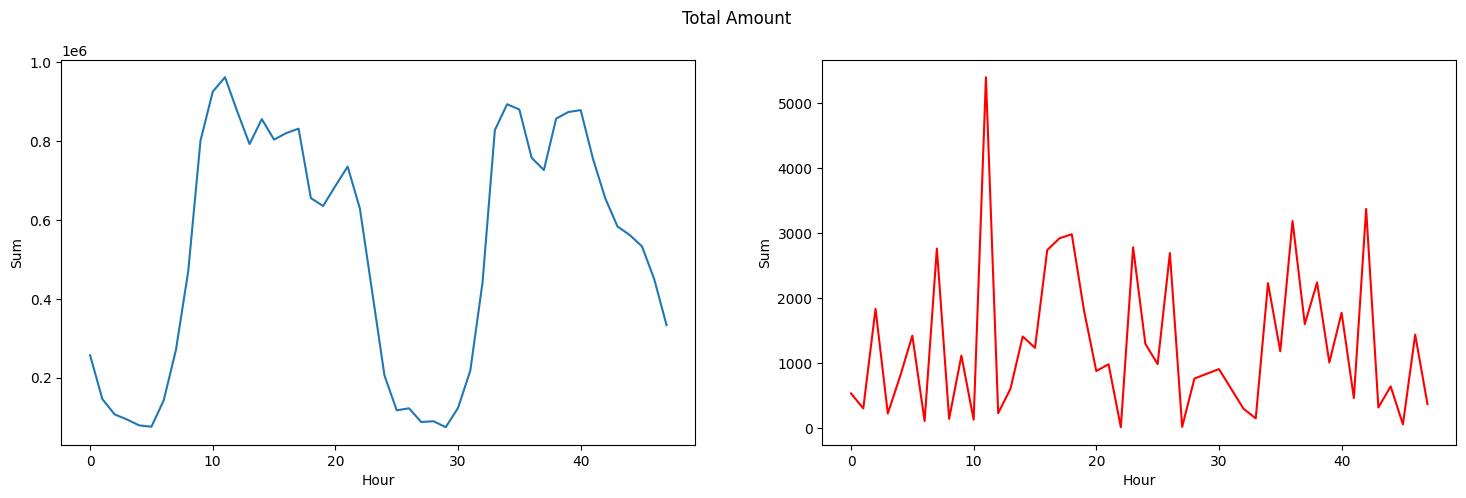

In [9]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,5))
s = sns.lineplot(ax = ax1, x="Hour", y="Sum", data=data_df.loc[data_df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Sum", data=data_df.loc[data_df.Class==1], color="red")
plt.suptitle("Total Amount")
plt.show();


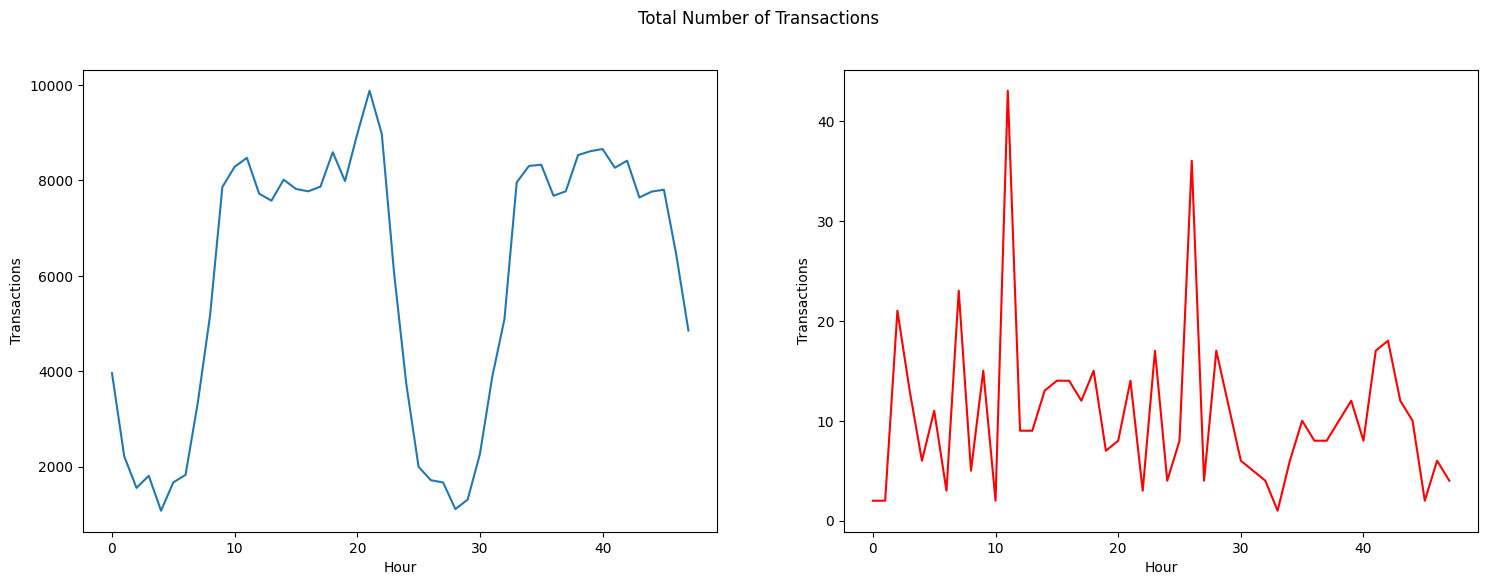

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Transactions", data=data_df.loc[data_df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Transactions", data=data_df.loc[data_df.Class==1], color="red")
plt.suptitle("Total Number of Transactions")
plt.show();

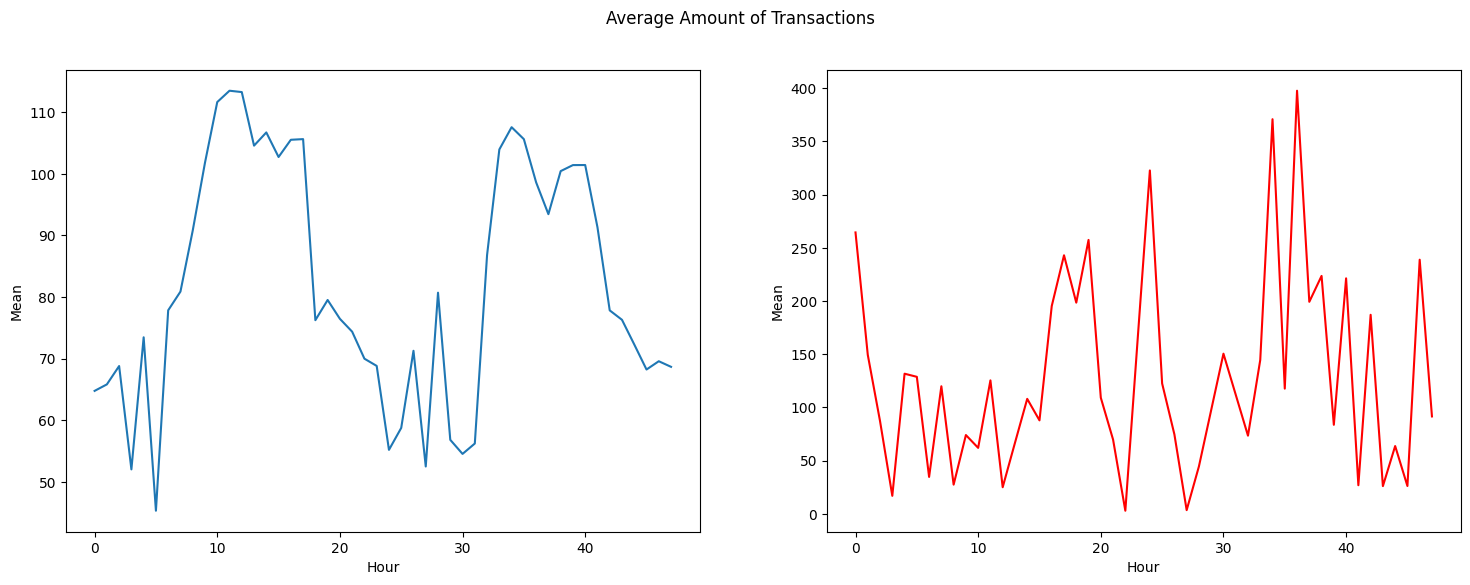

In [11]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Mean", data=data_df.loc[data_df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Mean", data=data_df.loc[data_df.Class==1], color="red")
plt.suptitle("Average Amount of Transactions")
plt.show();

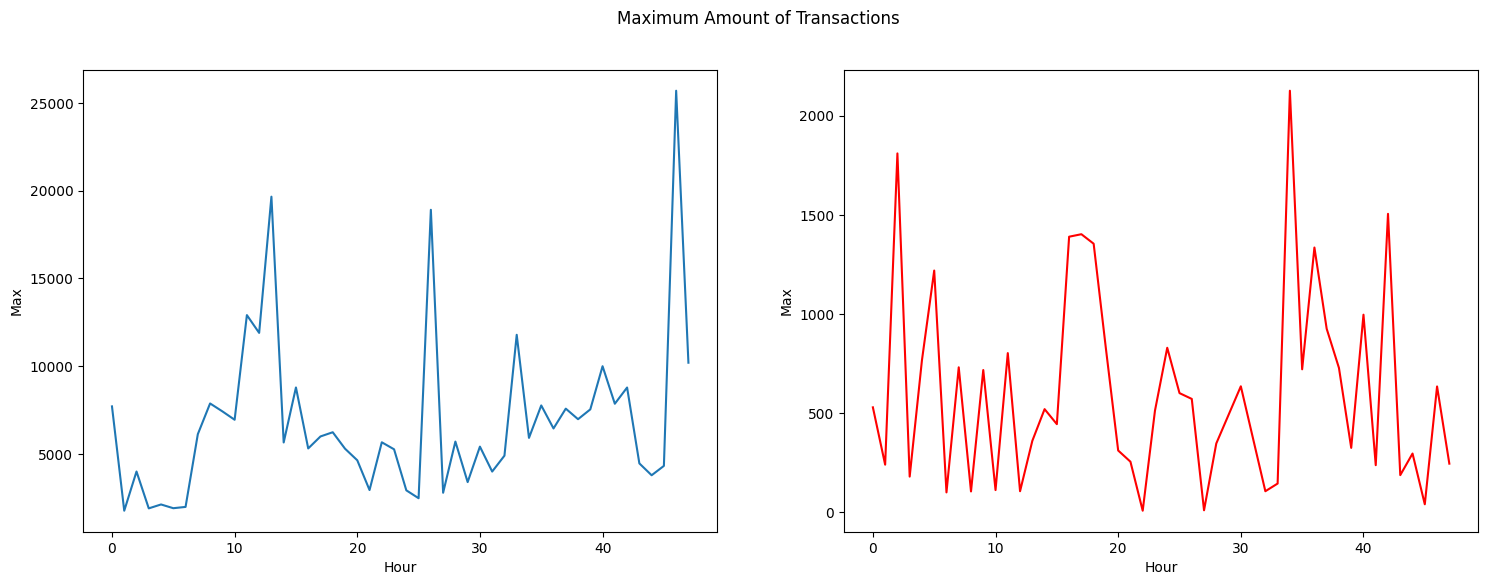

In [12]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Max", data=data_df.loc[data_df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Max", data=data_df.loc[data_df.Class==1], color="red")
plt.suptitle("Maximum Amount of Transactions")
plt.show();

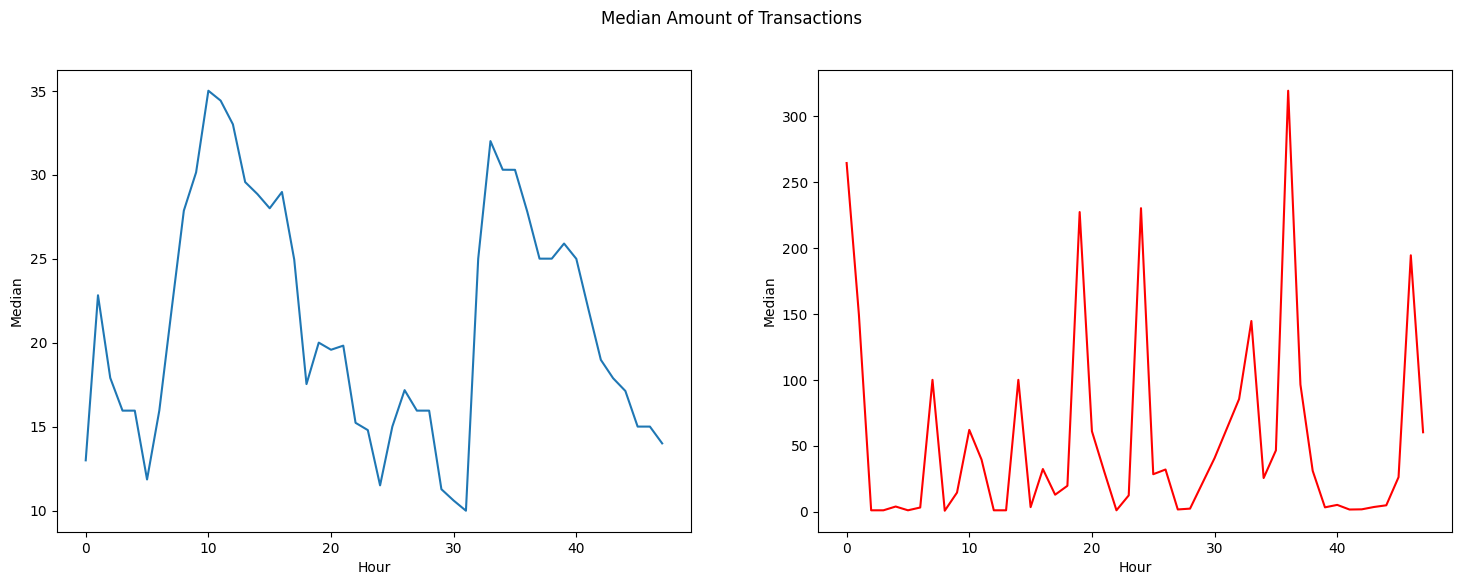

In [13]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Median", data=data_df.loc[data_df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Median", data=data_df.loc[data_df.Class==1], color="red")
plt.suptitle("Median Amount of Transactions")
plt.show();

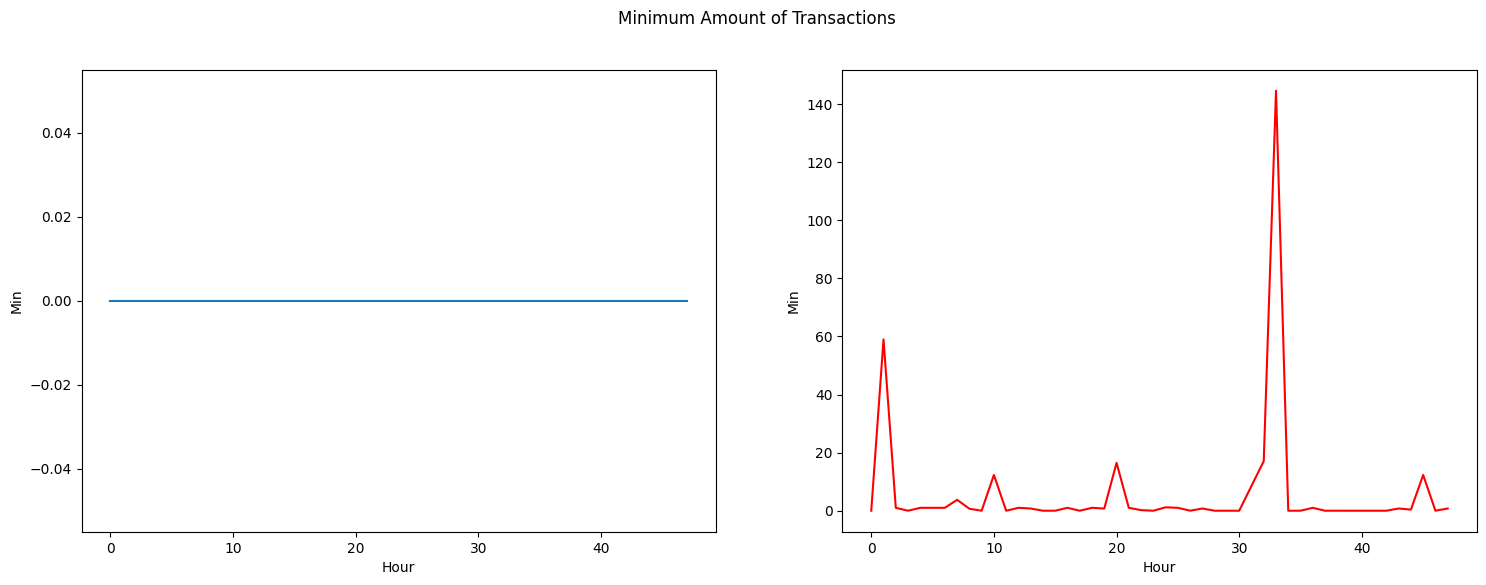

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Min", data=data_df.loc[data_df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Min", data=data_df.loc[data_df.Class==1], color="red")
plt.suptitle("Minimum Amount of Transactions")
plt.show();

2) Transaction amount

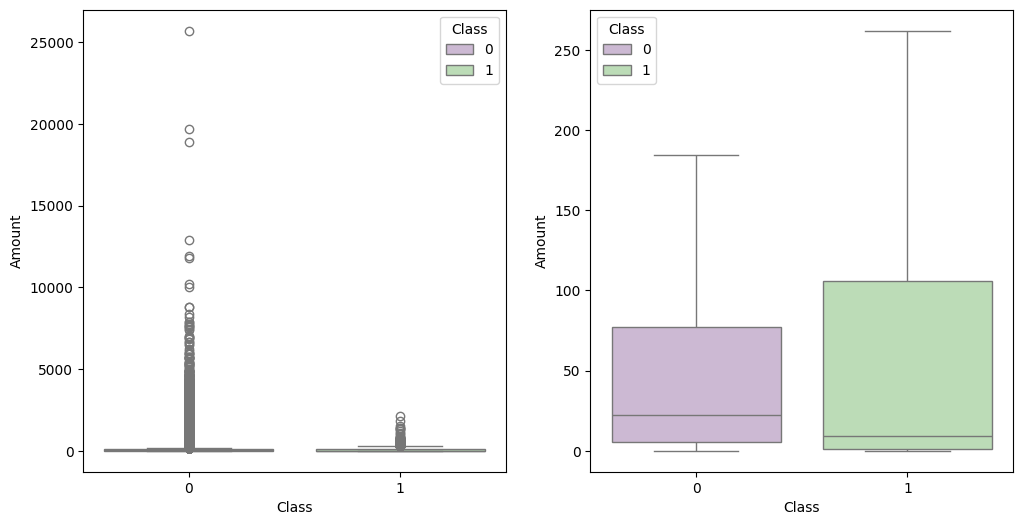

In [15]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="Class", y="Amount", hue="Class",data=df, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="Class", y="Amount", hue="Class",data=df, palette="PRGn",showfliers=False)
plt.show();

In [16]:
tmp = df[['Amount','Class']].copy()
class_0 = tmp.loc[tmp['Class'] == 0]['Amount']
class_1 = tmp.loc[tmp['Class'] == 1]['Amount']
class_0.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [17]:
class_1.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

The real transaction have a larger mean value, larger Q1, smaller Q3 and Q4 and larger outliers; fraudulent transactions have a smaller Q1 and mean, larger Q4 and smaller outliers.



Plotting the fraudulent transactions (amount) against time. The time is shown is seconds from the start of the time period (totaly 48h, over 2 days).

In [18]:
fraud = df.loc[df['Class'] == 1]

trace = go.Scatter(
    x = fraud['Time'],y = fraud['Amount'],
    name="Amount",
     marker=dict(
                color='rgb(238,23,11)',
                line=dict(
                    color='red',
                    width=1),
                opacity=0.5,
            ),
    text= fraud['Amount'],
    mode = "markers"
)
data = [trace]
layout = dict(title = 'Amount of fraudulent transactions',
          xaxis = dict(title = 'Time [s]', showticklabels=True), 
          yaxis = dict(title = 'Amount'),
          hovermode='closest'
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='fraud-amount')

Feature Correlation

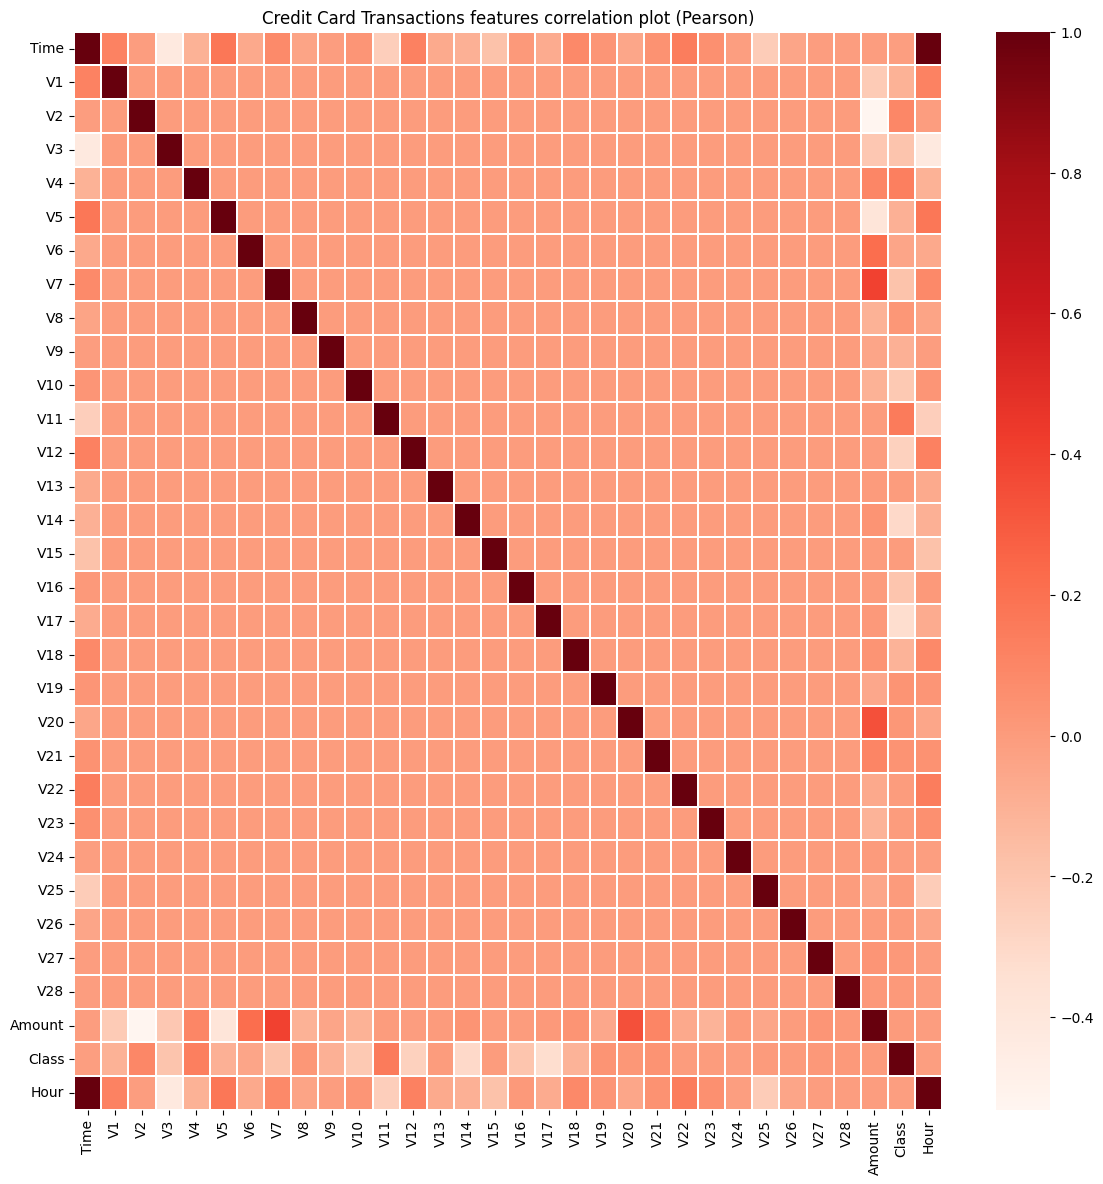

In [19]:
plt.figure(figsize = (14,14))
plt.title('Credit Card Transactions features correlation plot (Pearson)')
corr = df.corr()
# corr
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Reds")
plt.show()

As expected, there is no notable correlation between features V1-V28. There are certain correlations between some of these features and Time (inverse correlation with V3) and Amount (direct correlation with V7 and V20, inverse correlation with V1 and V5).



Plotting the correlated and inverse correlated values on the same graph.
Starting with the direct correlated values: {V20;Amount} and {V7;Amount}.

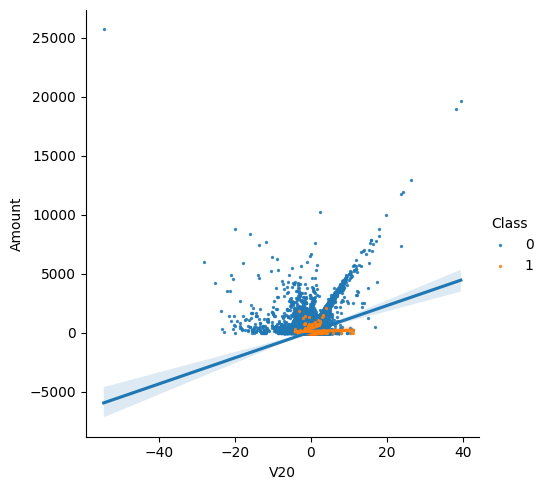

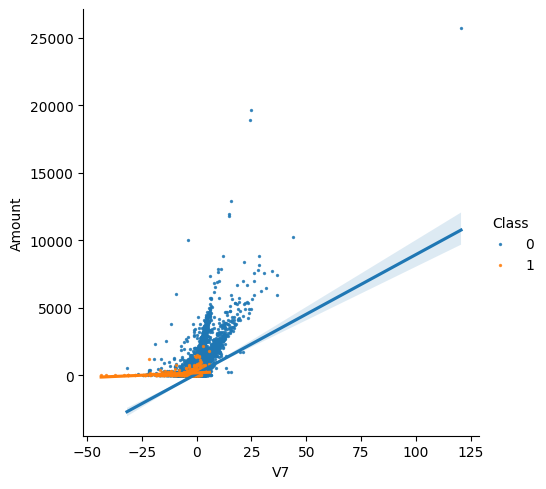

In [20]:
s = sns.lmplot(x='V20', y='Amount',data=df, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V7', y='Amount',data=df, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

Therefore the two couples of features are correlated (the regression lines for Class = 0 have a positive slope, whilst the regression line for Class = 1 have a smaller positive slope).



Now plotting the inverse correlated values.

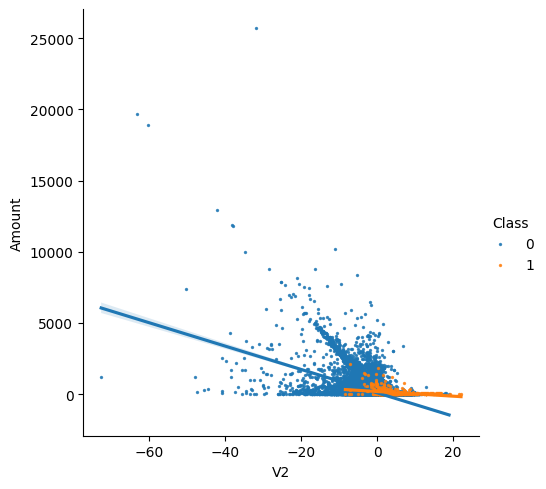

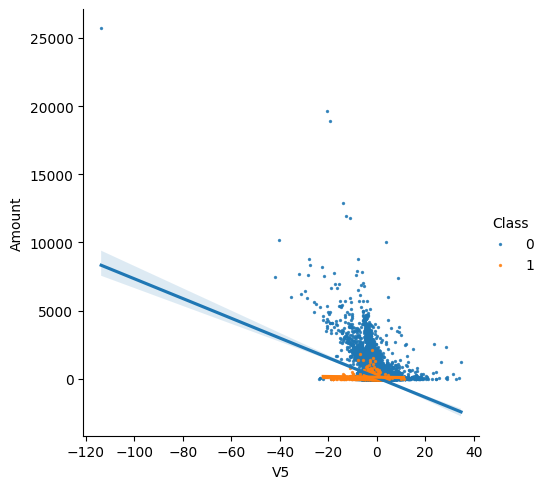

In [21]:
s = sns.lmplot(x='V2', y='Amount',data=df, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V5', y='Amount',data=df, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

Therefore the two couples of features are inverse correlated (the regression lines for Class = 0 have a negative slope while the regression lines for Class = 1 have a very small negative slope).

Features Density Plot

C:\Users\1464y\AppData\Local\Temp\ipykernel_21912\1452611049.py:14: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

C:\Users\1464y\AppData\Local\Temp\ipykernel_21912\1452611049.py:15: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.



<Figure size 640x480 with 0 Axes>

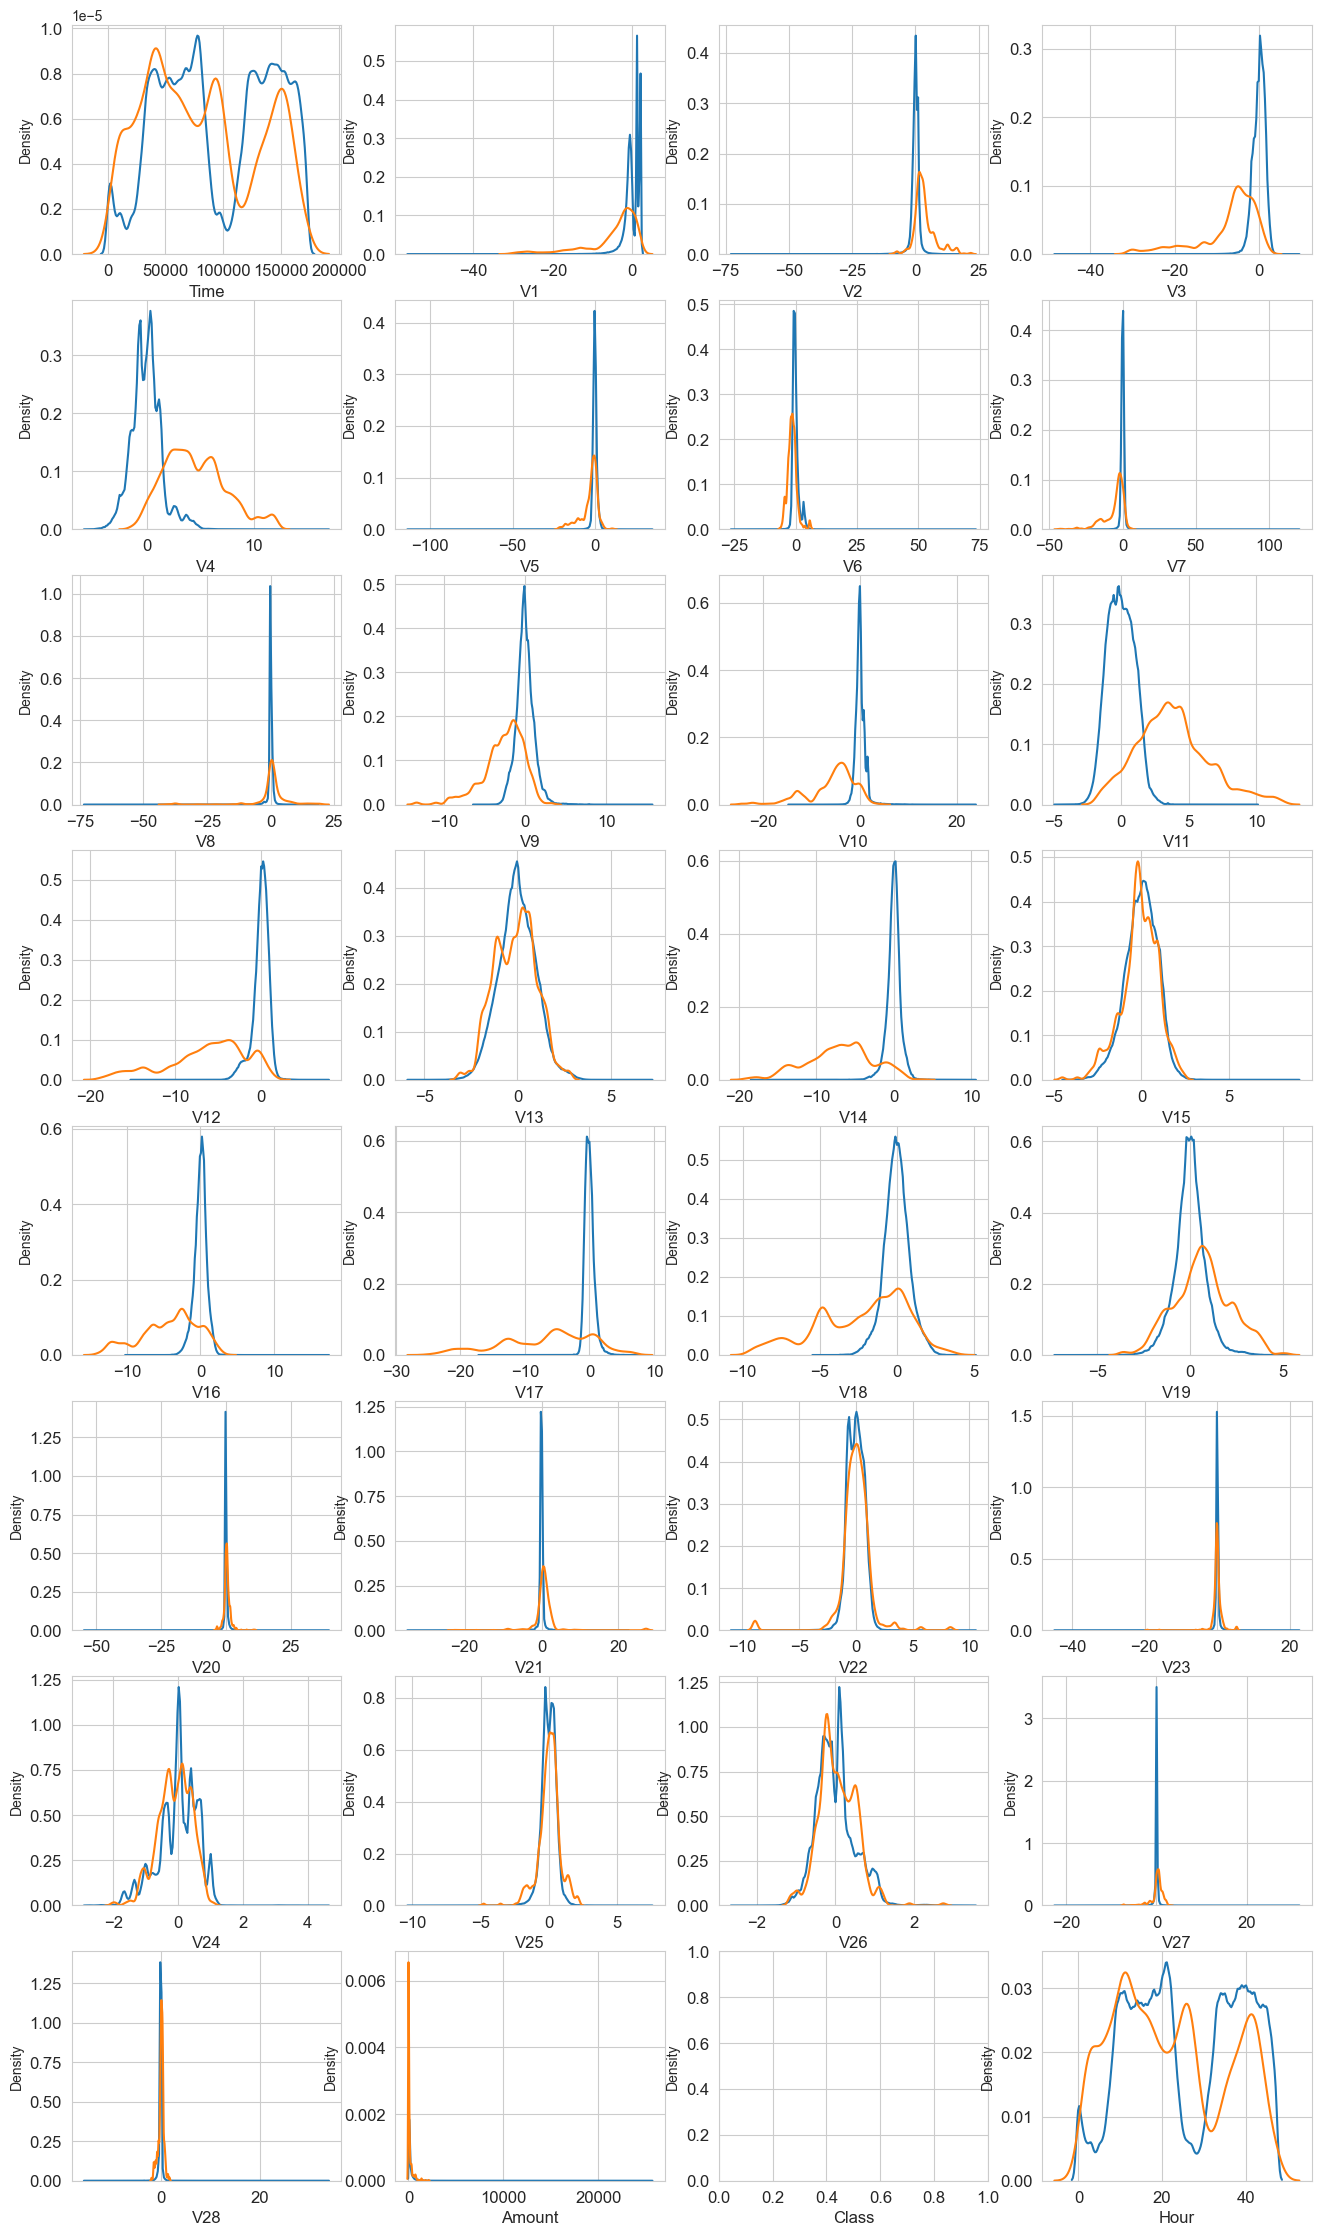

In [22]:
var = df.columns.values

i = 0
t0 = df.loc[df['Class'] == 0]
t1 = df.loc[df['Class'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,28))

for feature in var:
    i += 1
    plt.subplot(8,4,i)
    sns.kdeplot(t0[feature], bw_adjust=0.5, label="Class = 0")
    sns.kdeplot(t1[feature], bw_adjust=0.5, label="Class = 1")

    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

For some of the features we can observe a good selectivity in terms of distribution for the two values of Class: V4, V11 have clearly separated distributions for Class values 0 and 1, V12, V14, V18 are partially separated, V1, V2, V3, V10 have a quite distinct profile, whilst V25, V26, V28 have similar profiles for the two values of Class.

In general, with just few exceptions (Time and Amount), the features distribution for legitimate transactions (values of Class = 0) is centered around 0, sometime with a long queue at one of the extremities. In the same time, the fraudulent transactions (values of Class = 1) have a skewed (asymmetric) distribution.

Predictive Models

Define predictors and target values¶
Let's define the predictor features and the target features. Categorical features, if any, are also defined. In our case, there are no categorical feature.

In [23]:
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

Split data in train, test and validation set¶
Let's define train, validation and test sets.

In [24]:
train_df, test_df = train_test_split(df, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_df, valid_df = train_test_split(df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

RandomForestClassifier

Define model parameters¶
Let's set the parameters for the model.

Let's run a model using the training set for training. Then, we will use the validation set for validation.

We will use as validation criterion GINI, which formula is GINI = 2 * (AUC) - 1, where AUC is the Receiver Operating Characteristic - Area Under Curve (ROC-AUC) . Number of estimators is set to 100 and number of parallel jobs is set to 4.

We start by initializing the RandomForestClassifier.



In [25]:
clf = RandomForestClassifier(n_jobs=NO_JOBS, 
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

Training the RandonForestClassifier using the train_df data and fit function.

In [26]:
clf.fit(train_df[predictors], train_df[target].values)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Predicting the target values for the valid_df data, using predict function.

In [27]:
preds = clf.predict(valid_df[predictors])

Features importance

C:\Users\1464y\AppData\Local\Temp\ipykernel_21912\449442621.py:6: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



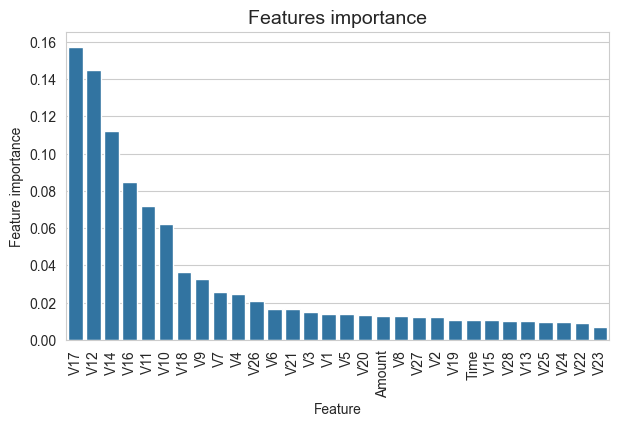

In [28]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show() 
# The most important features are V17, V12, V14, V10, V11, V16.

Confusion matrix

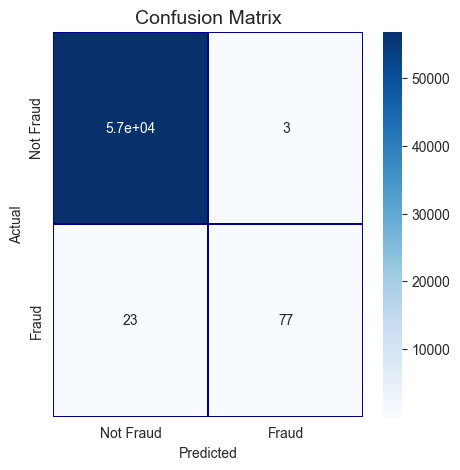

In [29]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

Area under curve

In [30]:
roc_auc_score(valid_df[target].values, preds)

0.8849736203439907

AdaBoostClassifier

In [47]:
clf = AdaBoostClassifier(random_state=RANDOM_STATE,
                         # algorithm='SAMME',
                         learning_rate=0.8,
                         n_estimators=NUM_ESTIMATORS)

In [50]:
clf.fit(train_df[predictors], train_df[target].values)

,estimator,None
,n_estimators,100
,learning_rate,0.8
,algorithm,'deprecated'
,random_state,2018


In [51]:
preds = clf.predict(valid_df[predictors])

C:\Users\1464y\AppData\Local\Temp\ipykernel_21912\3562096361.py:6: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



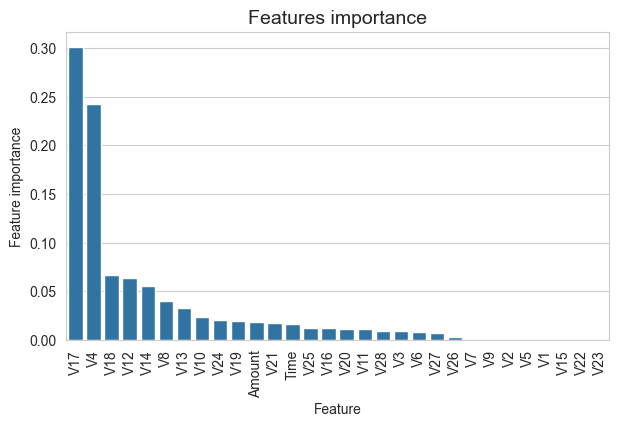

In [52]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()  

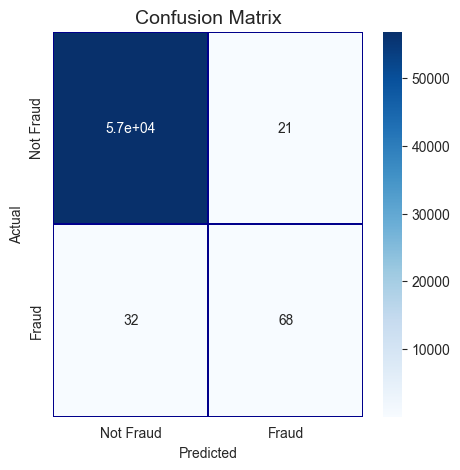

In [53]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [54]:
roc_auc_score(valid_df[target].values, preds)

0.8398153424079351

CatBoostClassifier:
CatBoostClassifier is a gradient boosting for decision trees algorithm with support for handling categorical data

In [55]:
clf = CatBoostClassifier(iterations=500,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='AUC',
                             random_seed = RANDOM_STATE,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = VERBOSE_EVAL,
                             od_wait=100)

In [56]:
clf.fit(train_df[predictors], train_df[target].values,verbose=True)

0:	total: 1.05s	remaining: 8m 46s
50:	total: 34.2s	remaining: 5m
100:	total: 1m 4s	remaining: 4m 16s
150:	total: 1m 34s	remaining: 3m 37s
200:	total: 2m 3s	remaining: 3m 3s
250:	total: 2m 33s	remaining: 2m 31s
300:	total: 3m 3s	remaining: 2m 1s
350:	total: 3m 34s	remaining: 1m 30s
400:	total: 4m 4s	remaining: 1m
450:	total: 4m 35s	remaining: 29.9s
499:	total: 5m 6s	remaining: 0us


In [57]:
preds = clf.predict(valid_df[predictors])

C:\Users\1464y\AppData\Local\Temp\ipykernel_21912\3992975389.py:6: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



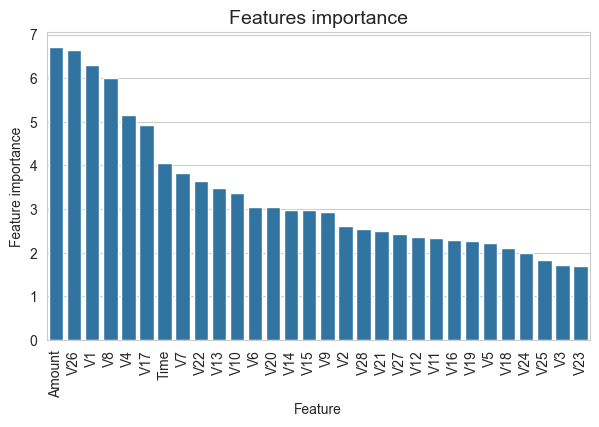

In [58]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

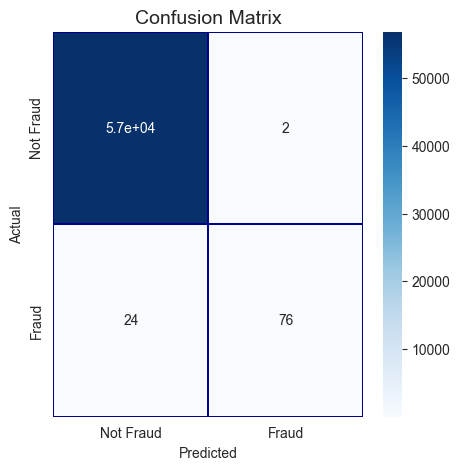

In [59]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [60]:
roc_auc_score(valid_df[target].values, preds)

0.8799824135626606

XGBoost
XGBoost is a gradient boosting algorithm.

Let's prepare the model.

Prepare the model
We initialize the DMatrix objects for training and validation, starting from the datasets. We also set some of the parameters used for the model tuning.

In [62]:
# Prepare the train and valid datasets
dtrain = xgb.DMatrix(train_df[predictors], train_df[target].values)
dvalid = xgb.DMatrix(valid_df[predictors], valid_df[target].values)
dtest = xgb.DMatrix(test_df[predictors], test_df[target].values)

#What to monitor (in this case, **train** and **valid**)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
# params['silent'] = True
params['verbosity'] = 0
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

In [65]:
# train
model = xgb.train(params, 
                dtrain, 
                MAX_ROUNDS, 
                evals=watchlist, 
                early_stopping_rounds=EARLY_STOP, 
                maximize=True, 
                verbose_eval=VERBOSE_EVAL)

[0]	train-auc:0.92535	valid-auc:0.91808
[50]	train-auc:0.98204	valid-auc:0.96146
[100]	train-auc:0.98903	valid-auc:0.97154
[150]	train-auc:0.99194	valid-auc:0.97272
[186]	train-auc:0.99323	valid-auc:0.97071


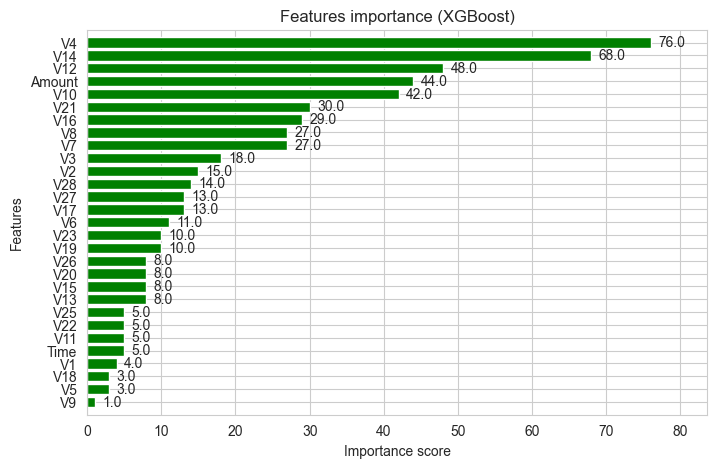

In [64]:
# Plot variable importance
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
xgb.plot_importance(model, height=0.8, title="Features importance (XGBoost)", ax=ax, color="green") 
plt.show()


In [66]:
# predict test set
preds = model.predict(dtest)

In [67]:
# Calculating ROC-AUC
roc_auc_score(test_df[target].values, preds)
# The AUC score for the prediction of fresh data (test set) is 0.974.

0.9707103162041433

LightGBM
Let's continue with another gradient boosting algorithm, LightGBM .

Define model parameters
Let's set the parameters for the model. We will use these parameters only for the first lgb model.

In [68]:
params = {
          'boosting_type': 'gbdt',
          'objective': 'binary',
          'metric':'auc',
          'learning_rate': 0.05,
          'num_leaves': 7,  # we should let it be smaller than 2^(max_depth)
          'max_depth': 4,  # -1 means no limit
          'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
          'max_bin': 100,  # Number of bucketed bin for feature values
          'subsample': 0.9,  # Subsample ratio of the training instance.
          'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
          'colsample_bytree': 0.7,  # Subsample ratio of columns when constructing each tree.
          'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
          'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
          'nthread': 8,
          'verbose': 0,
          'scale_pos_weight':150, # because training data is extremely unbalanced 
         }

In [69]:
dtrain = lgb.Dataset(train_df[predictors].values, 
                     label=train_df[target].values,
                     feature_name=predictors)

dvalid = lgb.Dataset(valid_df[predictors].values,
                     label=valid_df[target].values,
                     feature_name=predictors)

In [73]:
from lightgbm import early_stopping

kf = KFold(n_splits = NUMBER_KFOLDS, random_state = RANDOM_STATE, shuffle = True)

# Create arrays and dataframes to store results
oof_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()
n_fold = 0
for train_idx, valid_idx in kf.split(train_df):
    train_x, train_y = train_df[predictors].iloc[train_idx],train_df[target].iloc[train_idx]
    valid_x, valid_y = train_df[predictors].iloc[valid_idx],train_df[target].iloc[valid_idx]
    
    evals_results = {}
    model =  LGBMClassifier(
                  nthread=-1,
                  n_estimators=2000,
                  learning_rate=0.01,
                  num_leaves=80,
                  colsample_bytree=0.98,
                  subsample=0.78,
                  reg_alpha=0.04,
                  reg_lambda=0.073,
                  subsample_for_bin=50,boosting_type='gbdt',
                  is_unbalance=False,
                  min_split_gain=0.025,
                  min_child_weight=40,
                  min_child_samples=510,
                  objective='binary',
                  metric='auc',
                  silent=-1,
                  verbose=-1,
                  feval=None)
    model.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
                eval_metric= 'auc',  callbacks=[early_stopping(EARLY_STOP)])
    
    oof_preds[valid_idx] = model.predict_proba(valid_x, num_iteration=model.best_iteration_)[:, 1]
    test_preds += model.predict_proba(test_df[predictors], num_iteration=model.best_iteration_)[:, 1] / kf.n_splits
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = predictors
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
    del model, train_x, train_y, valid_x, valid_y
    gc.collect()
    n_fold = n_fold + 1
train_auc_score = roc_auc_score(train_df[target], oof_preds)
print('Full AUC score %.6f' % train_auc_score)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	training's auc: 0.976726	valid_1's auc: 0.98184
Fold  1 AUC : 0.981840
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	training's auc: 0.963505	valid_1's auc: 0.979296
Fold  2 AUC : 0.979296
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[78]	training's auc: 0.972725	valid_1's auc: 0.991758
Fold  3 AUC : 0.991758
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[78]	training's auc: 0.978658	valid_1's auc: 0.956518
Fold  4 AUC : 0.956518
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	training's auc: 0.976867	valid_1's auc: 0.979401
Fold  5 AUC : 0.979401
Full AUC score 0.929175


In [74]:
pred = test_preds

We investigated the data, checking for data unbalancing, visualizing the features and understanding the relationship between different features. We then investigated two predictive models. The data was split in 3 parts, a train set, a validation set and a test set. For the first three models, we only used the train and test set.

We started with RandomForrestClassifier, for which we obtained an AUC scode of 0.88 when predicting the target for the test set.

We followed with an AdaBoostClassifier model, with lower AUC score (0.83) for prediction of the test set target values.

We then followed with an CatBoostClassifier, with the AUC score after training 500 iterations 0.87.

We then experimented with a XGBoost model. In this case, se used the validation set for validation of the training model. The best validation score obtained was 0.984. Then we used the model with the best training step, to predict target value from the test data; the AUC score obtained was 0.974.

We then presented the data to a LightGBM model. We used both train-validation split and cross-validation to evaluate the model effectiveness to predict 'Class' value, i.e. detecting if a transaction was fraudulent. With the first method we obtained values of AUC for the validation set around 0.974. For the test set, the score obtained was 0.92.
With the cross-validation, we obtained an AUC score for the test prediction of 0.93.